<a href="https://colab.research.google.com/github/Mehul6112/Data-Science_curve/blob/main/Fraud_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
df = pd.read_csv("Fraud.csv")
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


**Info on Columns:**

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## Data Wrangling

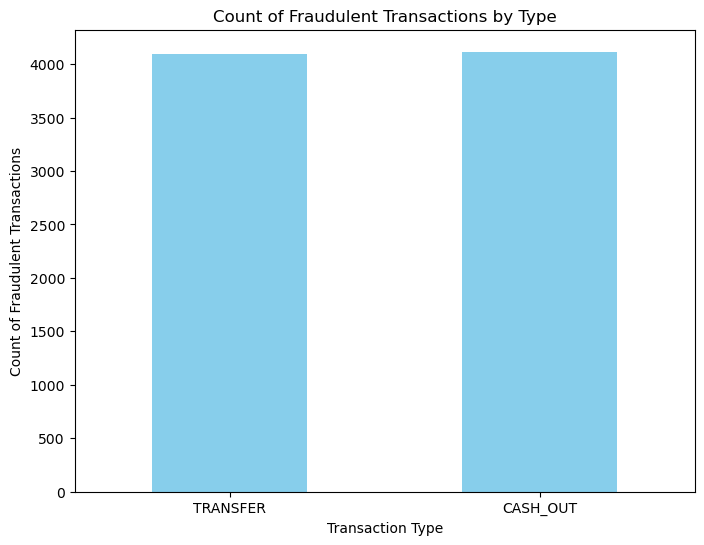

In [ ]:
fraud_by_type = df[df['isFraud'] == 1].groupby('type').size().sort_values()

plt.figure(figsize=(8, 6))
fraud_by_type.plot(kind='bar', color='skyblue')
plt.title('Count of Fraudulent Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count of Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

In [ ]:
#note that we have two types of customers, customer(start with "C") and Merchant(start with "M"). So converting "nameOrig" and "nameDest" to be useful in ML and preserve repeatition of same customers and merchants.
def is_merchant_dest(name):
  if isinstance(name, str):
    return name.startswith('M')
  else:
    return False

df['isMerchantDest'] = df['nameDest'].apply(lambda x: 1 if is_merchant_dest(x) else 0)

# -1 as a placeholder for imputation
df.loc[df['isMerchantDest'] == 1, 'oldbalanceDest'] = -1
df.loc[df['isMerchantDest'] == 1, 'newbalanceDest'] = -1

le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])


In [ ]:
### Removing outliers
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_no_outliers = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

In [ ]:
df_no_outliers.shape

(6024542, 12)

In [ ]:
df_no_outliers.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
isMerchantDest    0
dtype: int64

In [ ]:
df_no_outliers.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
isMerchantDest    0
dtype: int64

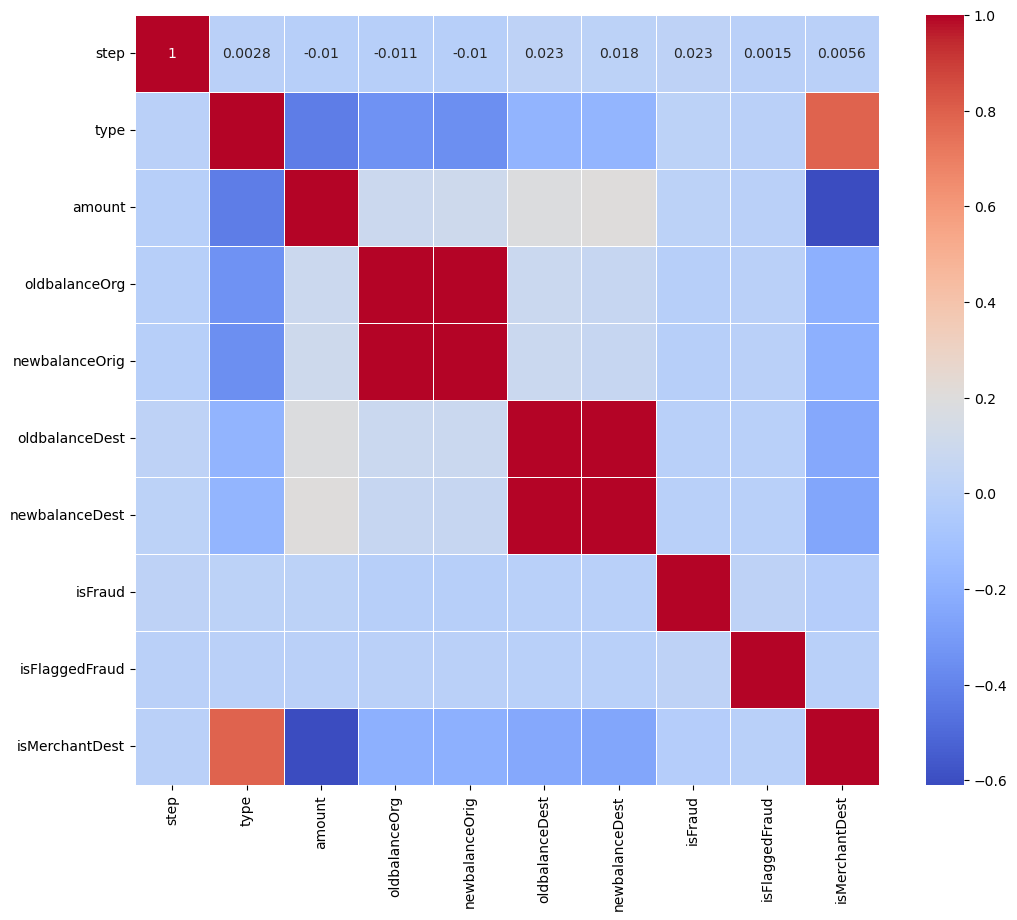

In [ ]:
correlation_matrix = df_no_outliers[["step","type","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest", "isFraud", "isFlaggedFraud", "isMerchantDest"]].corr()
# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [ ]:
columns_to_remove = ['nameOrig', 'nameDest', "isFlaggedFraud"]

# Create the new DataFrame for machine learning
ML_df = df_no_outliers.drop(columns=columns_to_remove)

# Machine Learning

In [ ]:
X = ML_df[["step", "type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isMerchantDest"]]
y = ML_df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

In [ ]:
scores_df = pd.DataFrame(columns=['Model', 'ROC AUC Score', 'Average Precision Score'])

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_probs = cross_val_predict(model, X, y, cv=kf, method='predict_proba')[:, 1]
    y_pred = cross_val_predict(model, X, y, cv=kf)

    roc_auc = roc_auc_score(y, y_probs)
    avg_precision = average_precision_score(y, y_probs)

    scores_df = pd.append([scores_df, pd.DataFrame({
        'Model': [model_name],
        'ROC AUC Score': [roc_auc],
        'Average Precision Score': [avg_precision]
    })], ignore_index=True)

scores_df

In [ ]:
fraud_df = df[df['isFraud'] == 1]
fraud_counts = fraud_df['nameOrig'].value_counts()
repeat_offenders = fraud_counts[fraud_counts > 1]
print("Customers who have committed fraud repeatedly:")
print(repeat_offenders)

Customers who have committed fraud repeatedly:
Series([], Name: count, dtype: int64)


In [ ]:
#Looks like ther are no repeat offenders.